# Assignment 6

CS4172 Machine Learning Lab

Name: Abhiroop Mukherjee

Enrolment Number: 510519109

## Task 1

Download and extract the flower image dataset from https://www.kaggle.com/alxmamaev/flowers-recognition.

## Task 2

The dataset contains five classes of flower images of variable sizenamely chamomile, tulip, rose, sunflower, dandelion. Resize all images to 80*80 pixels and convert all color images to grey images.

## Task 3

Randomly shuffle all images to create training, test set with ratio of 90:10, respectively. (Reduce the training size by 1/ 5 if computation resources are limited).

In [1]:
import tensorflow as tf
import random 


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" #ignore CUDA messages

DATASET_DIRECTORY_PATH = '../ML_DRIVE/Assign_6/flowers/'
seed = random.randint(0,100)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= DATASET_DIRECTORY_PATH,
    labels="inferred",
    label_mode="categorical", #output of model will be softmax categorical
    color_mode="grayscale",
    batch_size=32,
    image_size=(80,80),
    shuffle=True,
    seed=seed, #same seed for both dataset so that no overlap happens
    validation_split=0.1, #90:10 split
    subset='training',
    crop_to_aspect_ratio=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory= DATASET_DIRECTORY_PATH,
    labels="inferred",
    label_mode="categorical", #output of model will be softmax categorical
    color_mode="grayscale",
    batch_size=32,
    image_size=(80,80),
    shuffle=True,
    seed=seed,
    validation_split=0.1, #90:10 split
    subset='validation',
    crop_to_aspect_ratio=False,
)

Found 4317 files belonging to 5 classes.
Using 3886 files for training.
Found 4317 files belonging to 5 classes.
Using 431 files for validation.


In [2]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## Task 4

Train a Convolutional neural network with max pooling and a fully connected layer at the top, to classify the flower images. Now run the network by changing the following hyper-parameters:

In [3]:
INPUT_SHAPE = (80, 80, 1)
NUM_CLASS = 5


In [4]:
from bdb import effective
from tensorflow.keras import Sequential
from tensorflow.keras.layers import \
    Conv2D, Dense, Input, MaxPool2D, Flatten, \
    Dropout, AvgPool2D, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.math import confusion_matrix
import numpy as np
import seaborn as sns

LRELU_APLHA = 0.01


def _plot_history(
    history: 'tf.keras.callbacks.History',
    conv_kernels: 'list[tuple[int, int]]',
    conv_filters: 'list[int]',
    activation: 'str',
    pool: 'str',
    num_fc_layers: 'int'
):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title(f'Loss vs epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.title(f'Accuracy vs epoch')

    plt.suptitle(
        f'filters {conv_filters}; kernels {conv_kernels}; {pool}_pool; {activation}; dense layers after flatten= {num_fc_layers}')
    plt.show()


def _plot_confusion_matrix(y_val: 'list[int]',
                           y_pred: 'list[int]'):
    matrix = confusion_matrix(y_val, y_pred)
    fig = plt.figure(figsize=(12, 5))
    sns.heatmap(
        matrix,
        xticklabels=range(1, NUM_CLASS + 1),
        yticklabels=range(1, NUM_CLASS + 1),
        linewidth=0.5,
        cmap='coolwarm',
        annot=True,
        cbar=True)
    plt.title('Confusion Matrix for the above model')
    plt.ylabel('Actual Value')
    plt.xlabel('Predicted Value')
    plt.show()


def train_model(
    conv_kernels: 'list[tuple[int, int]]',
    conv_filters: 'list[int]',
    activation: 'str',
    pool: 'str',
    drop_rate: 'float',
    num_fc_layers: 'int',
    train_dataset: "tf.data.Dataset",
    val_dataset: "tf.data.Dataset",
    add_batch_norm=False,
    fc_layer_size=64,
    num_epochs=100,
    extra_conv_layers=0
):

    model = Sequential()
    model.add(Input(shape=INPUT_SHAPE))

    for filtr, kernel in zip(conv_filters, conv_kernels):
        if activation == 'lrelu':
            model.add(Conv2D(
                filters=filtr,
                kernel_size=kernel,
                activation=LeakyReLU(alpha=LRELU_APLHA)
            ))
        else:
            model.add(Conv2D(
                filters=filtr,
                kernel_size=kernel,
                activation=activation
            ))

        if pool.lower() == 'max':
            model.add(MaxPool2D())
        elif pool.lower() == 'avg':
            model.add(AvgPool2D())
        else:
            raise Exception('argument pool is undefined')

        if add_batch_norm:
            model.add(BatchNormalization())

        if drop_rate > 0:
            model.add(Dropout(rate=drop_rate))

    # add extra_conv_layers

    # also padding "same" cause image dimension is reducing to 0 otherwise
    for i in range(0, extra_conv_layers):
        conv_filters.append(conv_filters[-1]*2)
        conv_kernels.append(conv_kernels[-1])

        if activation == 'lrelu':
            model.add(Conv2D(
                filters=conv_filters[-1],
                kernel_size=conv_kernels[-1],
                activation=LeakyReLU(alpha=LRELU_APLHA),
                padding='same'
            ))
        else:
            model.add(Conv2D(
                filters=conv_filters[-1],
                kernel_size=conv_kernels[-1],
                activation=activation,
                padding='same'
            ))

    model.add(Flatten())

    for _ in range(num_fc_layers):
        if activation == 'lrelu':
            model.add(Dense(
                units=fc_layer_size,
                activation=LeakyReLU(alpha=LRELU_APLHA)
            ))
        else:
            model.add(Dense(
                units=fc_layer_size,
                activation=activation
            ))

    model.add(Dense(units=NUM_CLASS, activation='softmax'))

    # model.summary()

    model.compile(loss=CategoricalCrossentropy(),
                  metrics=['accuracy', Precision(), Recall()])

    callback = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]

    history = model.fit(x=train_dataset,
                        epochs=num_epochs,
                        verbose=0,
                        callbacks=callback if num_epochs == 100 else None,
                        validation_data=val_dataset
                        )

    val_loss, val_accuracy, val_precision, val_recall = \
        model.evaluate(val_dataset, verbose=0)

    _plot_history(
        history=history,
        conv_filters=conv_filters,
        conv_kernels=conv_kernels,
        activation=activation,
        pool=pool,
        num_fc_layers=num_fc_layers
    )

    # convert categorical to numeric for confusion matrix plotting
    y_val = [np.argmax(res) for res in np.concatenate(
        [y for x, y in val_dataset], axis=0)]
    y_predict = [np.argmax(res) for res in model.predict(val_dataset)]
    _plot_confusion_matrix(y_val, y_predict)

    return val_loss, val_accuracy, val_precision, val_recall


### Task 4.1

Analyze the performance of convolution window kernel size

| Convolution Layer | Convolution kernel_size | Convolution filters size | Pooling Layers | Activation | FC layer (after Flatten) | Regularization                  |
|-------------------|-------------------------|--------------------------|----------------|------------|--------------------------|---------------------------------|
| 3                 | (3\*3, 3\*3, 3\*3)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |
| 3                 | (3\*3, 3\*3, 5\*5)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |
| 3                 | (3\*3, 5\*5, 5\*5)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |
| 3                 | (5\*5, 5\*5, 5\*5)         | \[16,32,64\]               | Max_Pooling    | Relu       | 1                        | Dropout of 0.1 after each layer |

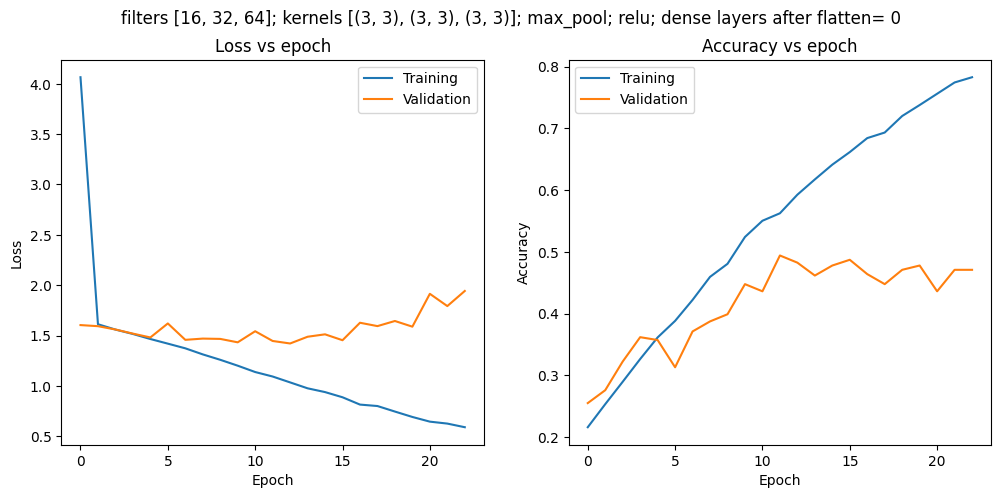

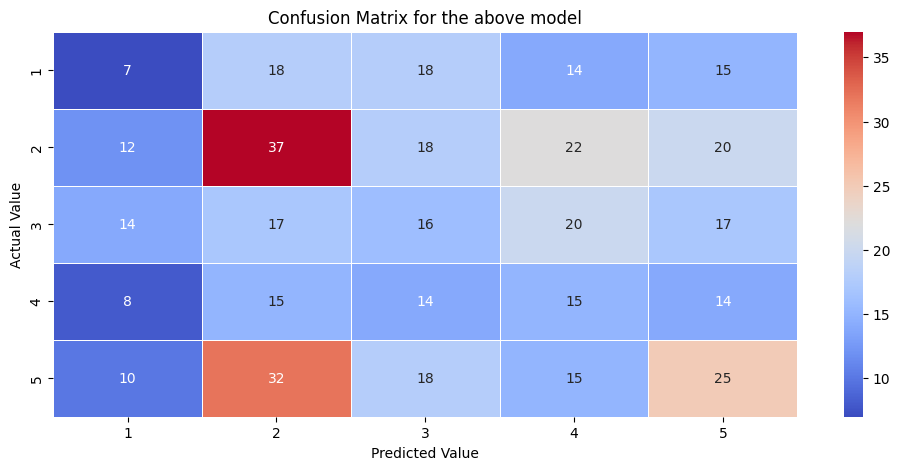

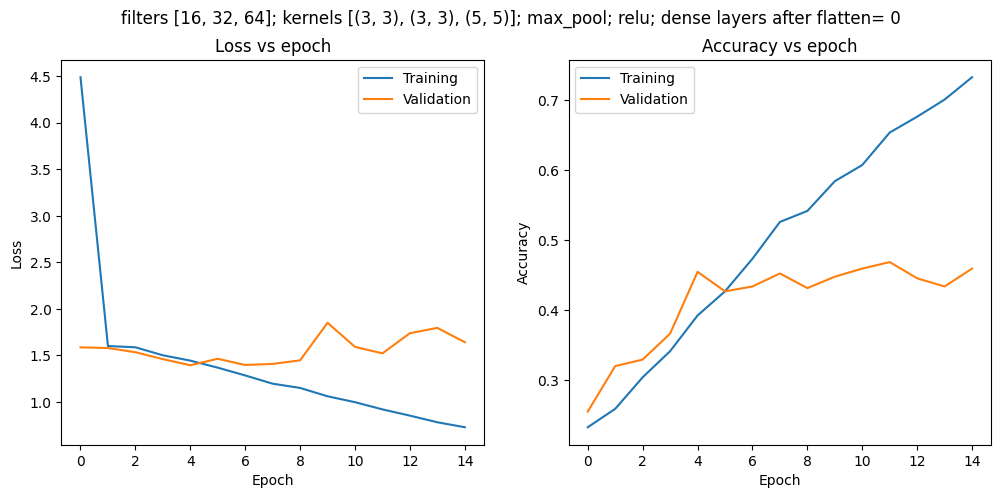

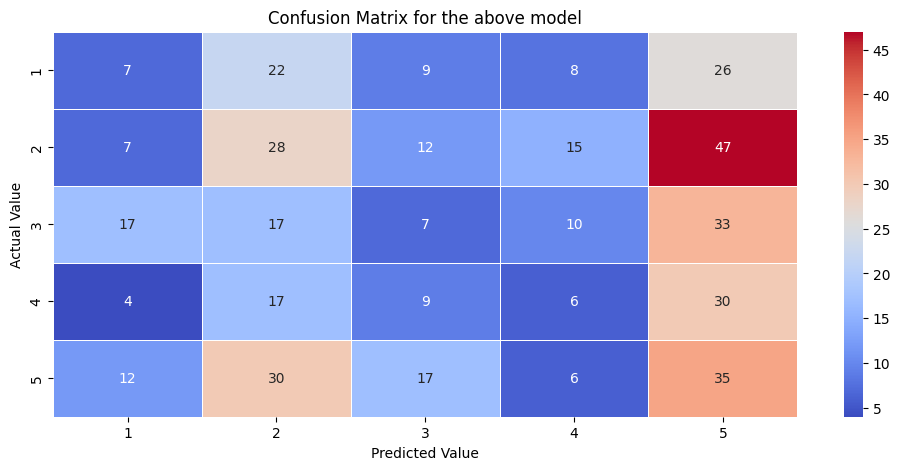

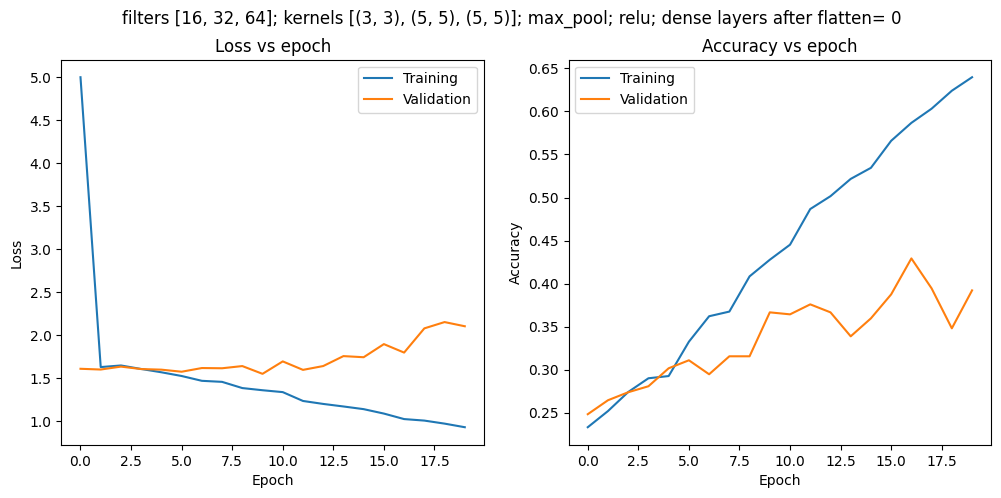

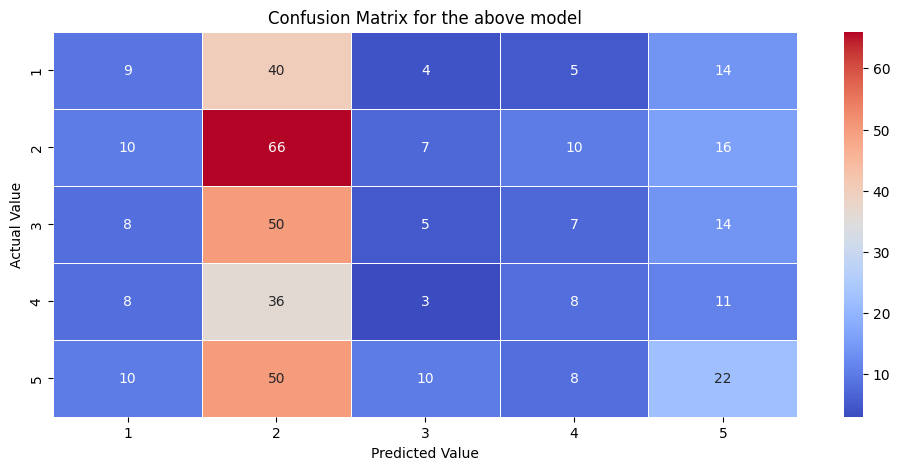

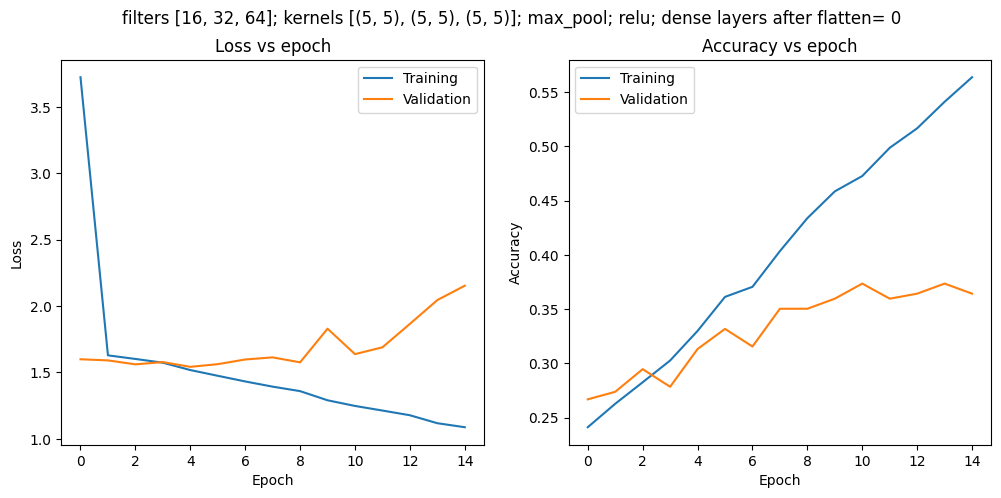

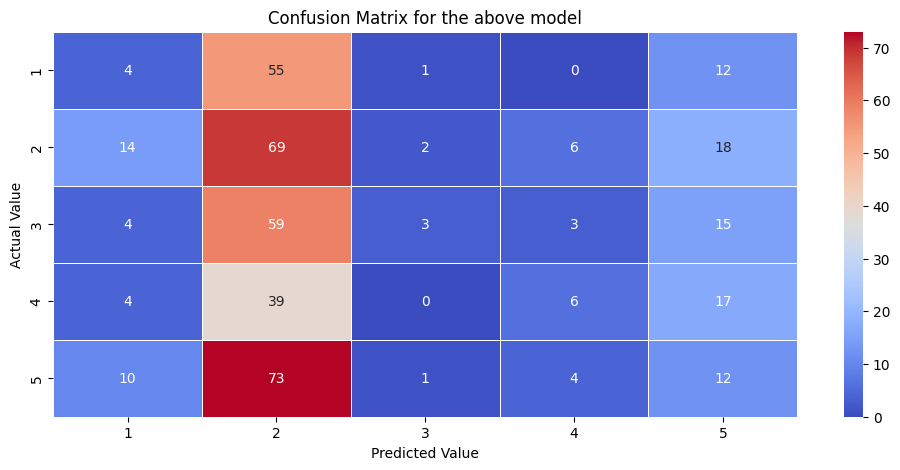

In [5]:
import pandas as pd

result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall'
])

convolution_kernels = [
    [(3, 3), (3, 3), (3, 3)],
    [(3, 3), (3, 3), (5, 5)],
    [(3, 3), (5, 5), (5, 5)],
    [(5, 5), (5, 5), (5, 5)],
]
convolution_filters = [16, 32, 64]
activation = 'relu'
dropout_rate = 0.1
num_fc_layers = 0
pool='max'

for kernels in convolution_kernels:
    val_loss, val_acc, val_precision, val_recall = train_model(
        drop_rate=dropout_rate,
        conv_kernels=kernels,
        conv_filters=convolution_filters,
        activation=activation,
        pool=pool,
        num_fc_layers=num_fc_layers,
        train_dataset=train_dataset,
        val_dataset=val_dataset
    )

    result.loc[len(result.index)] = [
        kernels,
        convolution_filters,
        pool,
        activation,
        num_fc_layers,
        dropout_rate,
        val_loss,
        val_acc,
        val_precision, 
        val_recall 
    ]

In [6]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation f1
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,0,0.1,1.420821,0.482599,0.586854,0.290023,0.388199
1,"[(3, 3), (3, 3), (5, 5)]","[16, 32, 64]",max,relu,0,0.1,1.394655,0.454756,0.611842,0.215777,0.319039
2,"[(3, 3), (5, 5), (5, 5)]","[16, 32, 64]",max,relu,0,0.1,1.549448,0.366589,0.509434,0.125290,0.201117
3,"[(5, 5), (5, 5), (5, 5)]","[16, 32, 64]",max,relu,0,0.1,1.541620,0.313225,0.521739,0.083527,0.144000


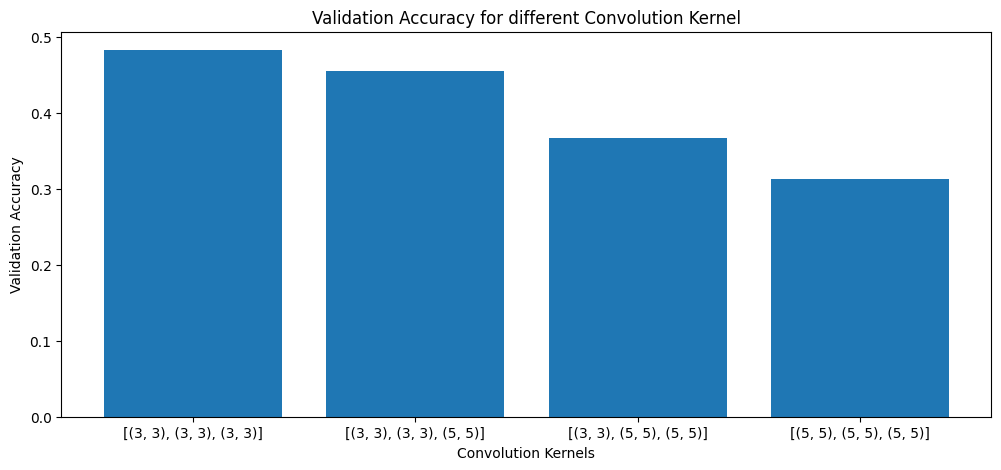

In [7]:
plt.figure(figsize=(12, 5))
plt.bar(
    [str(res) for res in result['Convolution kernel_size']],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Convolution Kernels')
plt.title("Validation Accuracy for different Convolution Kernel")
plt.show()


In [9]:
best_conv_kernel = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
)['Convolution kernel_size'].iloc[0]

best_conv_kernel


[(3, 3), (3, 3), (3, 3)]

### Task 4.2

For the best set of parameters obtained above, use two and three FC layers(After Flatten).

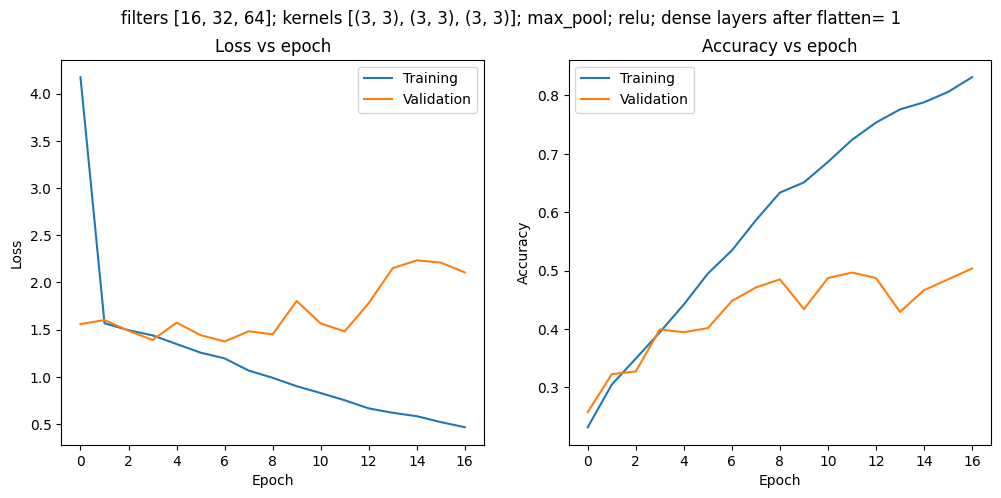

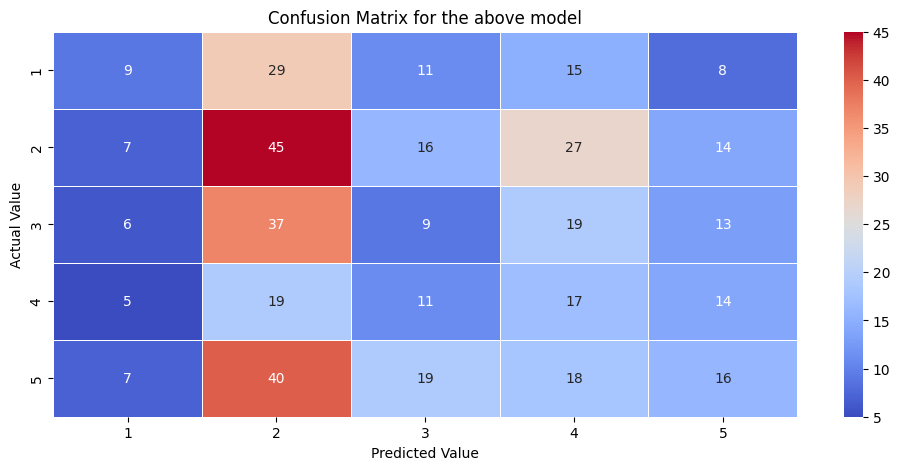

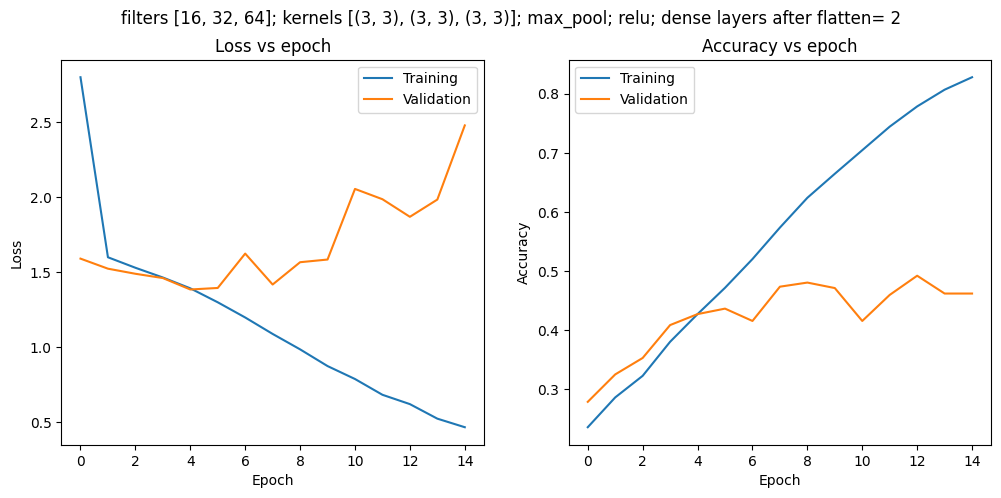

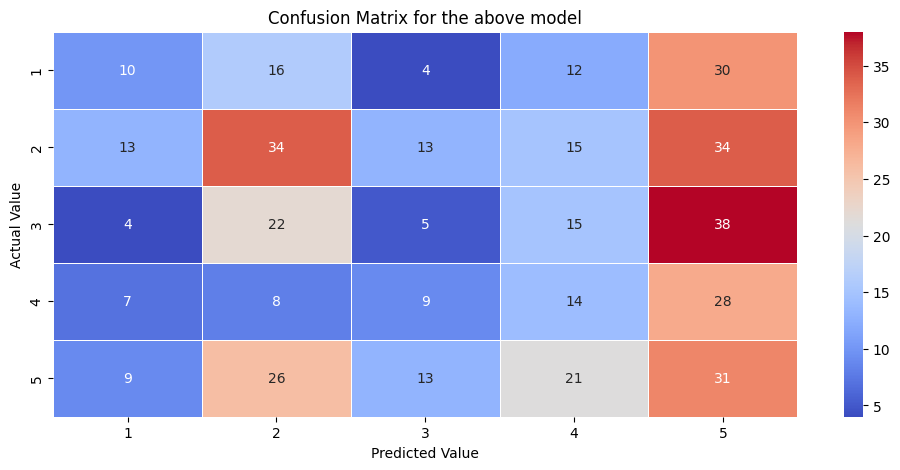

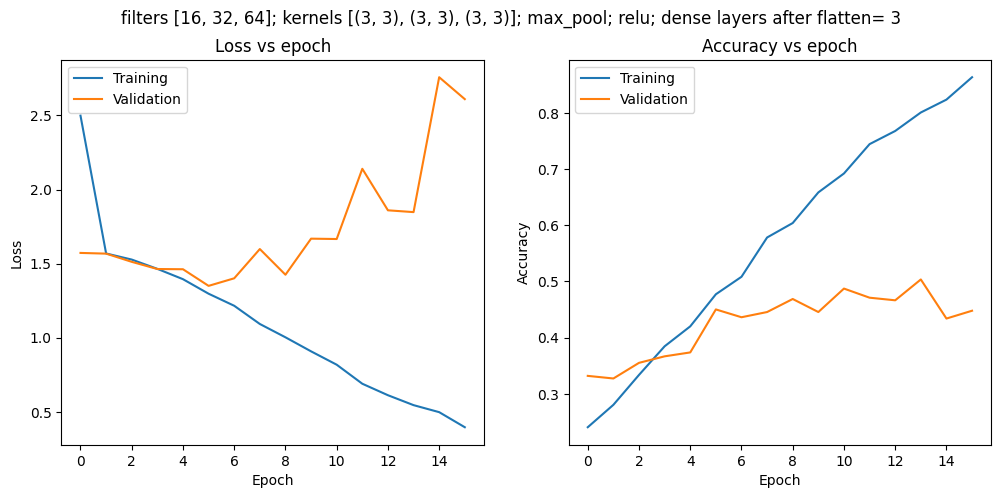

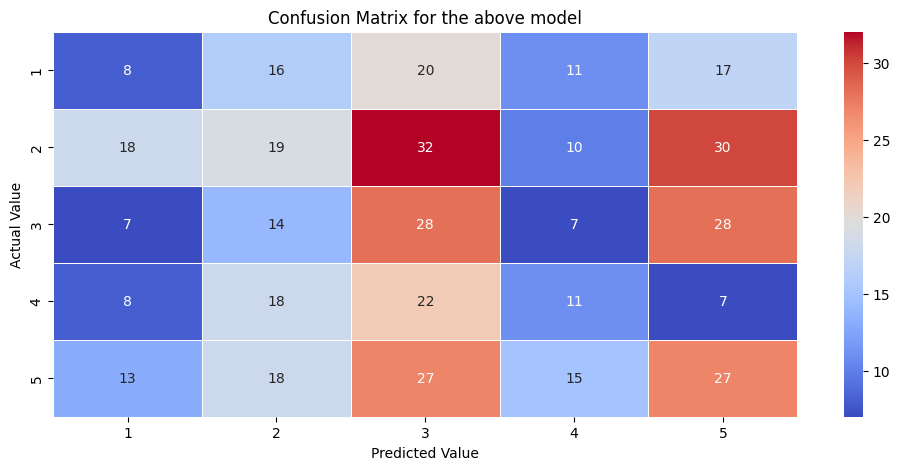

In [10]:
result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall'
])

convolution_filters = [16, 32, 64]
activation = 'relu'
dropout_rate = 0.1
num_fc_layers = [1, 2, 3]
pool = 'max'

for layers in num_fc_layers:
    val_loss, val_acc, val_precision, val_recall = train_model(
        drop_rate=dropout_rate,
        conv_kernels=best_conv_kernel,
        conv_filters=convolution_filters,
        activation=activation,
        pool=pool,
        num_fc_layers=layers,
        train_dataset=train_dataset,
        val_dataset=val_dataset
    )

    result.loc[len(result.index)] = [
        best_conv_kernel,
        convolution_filters,
        pool,
        activation,
        layers,
        dropout_rate,
        val_loss,
        val_acc,
        val_precision,
        val_recall
    ]


In [11]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation f1
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,1,0.1,1.375230,0.447796,0.613924,0.225058,0.329372
1,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,2,0.1,1.383225,0.426914,0.771429,0.125290,0.215569
2,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.1,1.349801,0.450116,0.707865,0.146172,0.242308


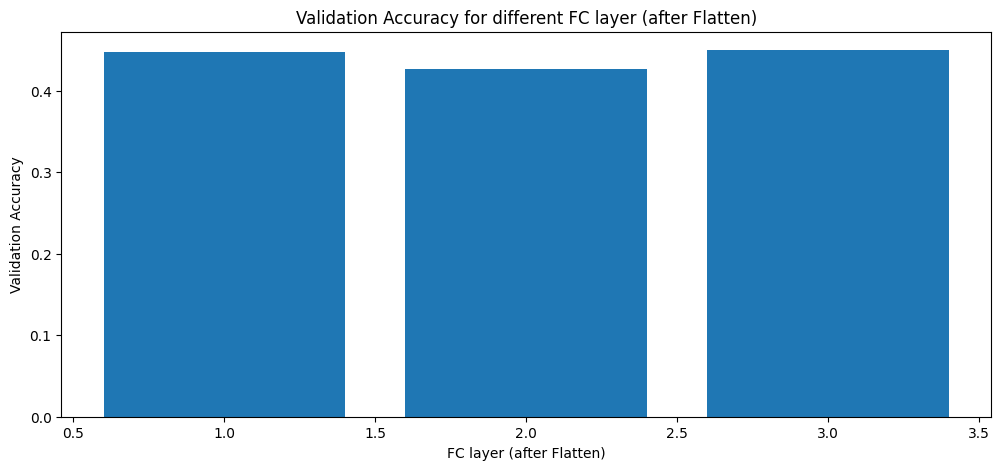

In [12]:
plt.figure(figsize=(12, 5))
plt.bar(
    result['FC layer (after Flatten)'],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('FC layer (after Flatten)')
plt.title("Validation Accuracy for different FC layer (after Flatten)")
plt.show()


In [13]:
best_num_fc_layers = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['FC layer (after Flatten)'].iloc[0]

best_num_fc_layers

3

### Task 4.3

For the best set of parameters obtained above, use average pooling instead of Max pooling.

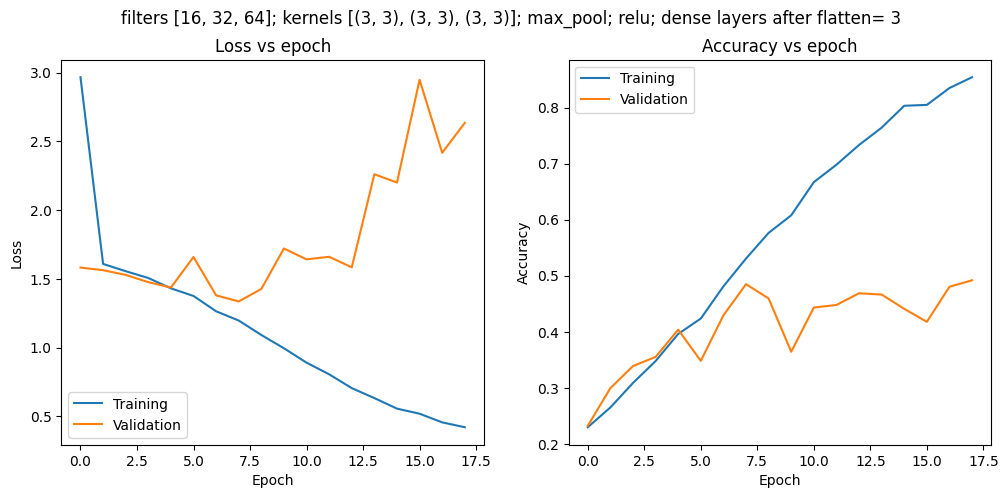

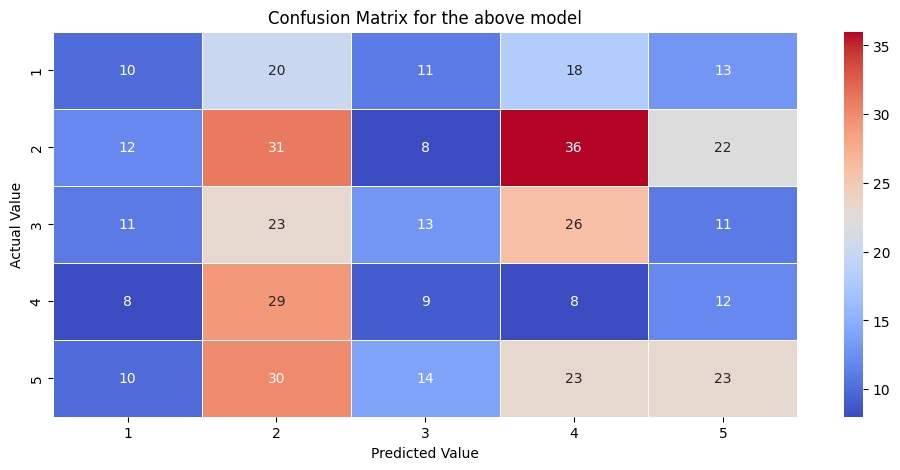

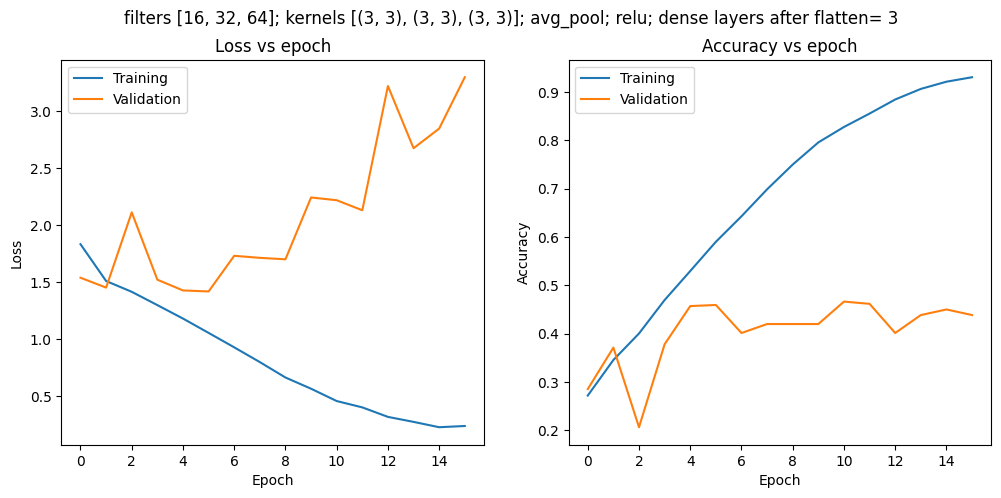

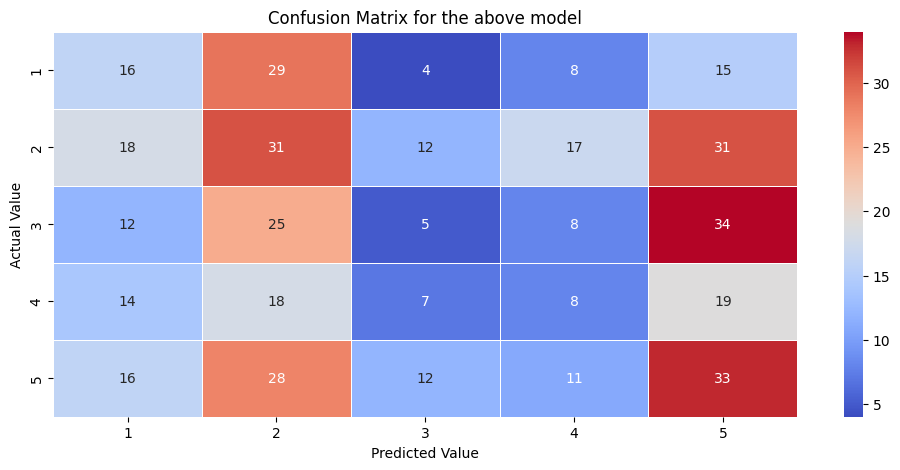

In [14]:
result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall'
])

convolution_filters = [16, 32, 64]
activation = 'relu'
dropout_rate = 0.1
pools = ['max', 'avg']

for pool in pools:
    val_loss, val_acc, val_precision, val_recall = train_model(
        drop_rate=dropout_rate,
        conv_kernels=best_conv_kernel,
        conv_filters=convolution_filters,
        activation=activation,
        pool=pool,
        num_fc_layers=best_num_fc_layers,
        train_dataset=train_dataset,
        val_dataset=val_dataset
    )

    result.loc[len(result.index)] = [
        best_conv_kernel,
        convolution_filters,
        pool,
        activation,
        best_num_fc_layers,
        dropout_rate,
        val_loss,
        val_acc,
        val_precision,
        val_recall
    ]


In [15]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation f1
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.1,1.336434,0.484919,0.674847,0.255220,0.37037
1,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",avg,relu,3,0.1,1.418009,0.459397,0.622951,0.352668,0.45037


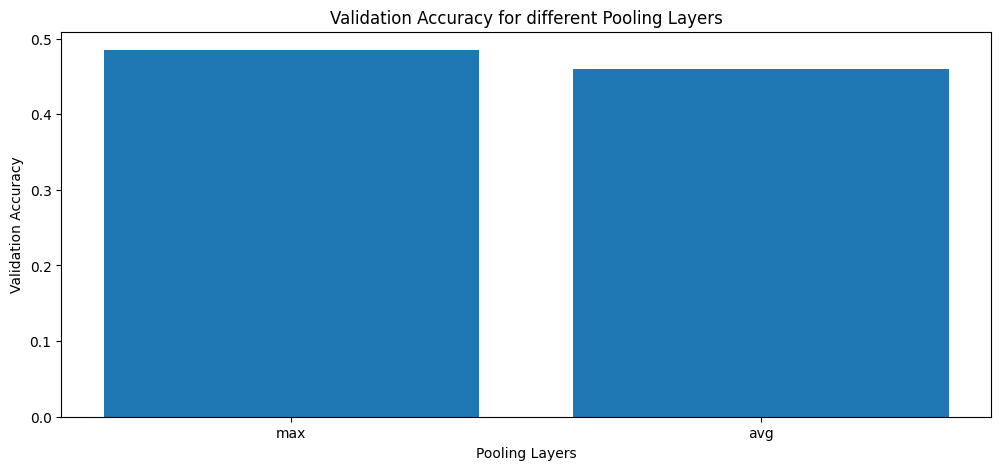

In [16]:
plt.figure(figsize=(12, 5))
plt.bar(
    result['Pooling Layers'],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Pooling Layers')
plt.title("Validation Accuracy for different Pooling Layers")
plt.show()

In [17]:
best_pool = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['Pooling Layers'].iloc[0]

best_pool

'max'

### Task 4.4

For the best set of parameters obtained above, use the activation function: Sigmoid, ELU, Leaky Relu (alpha= 0.01)

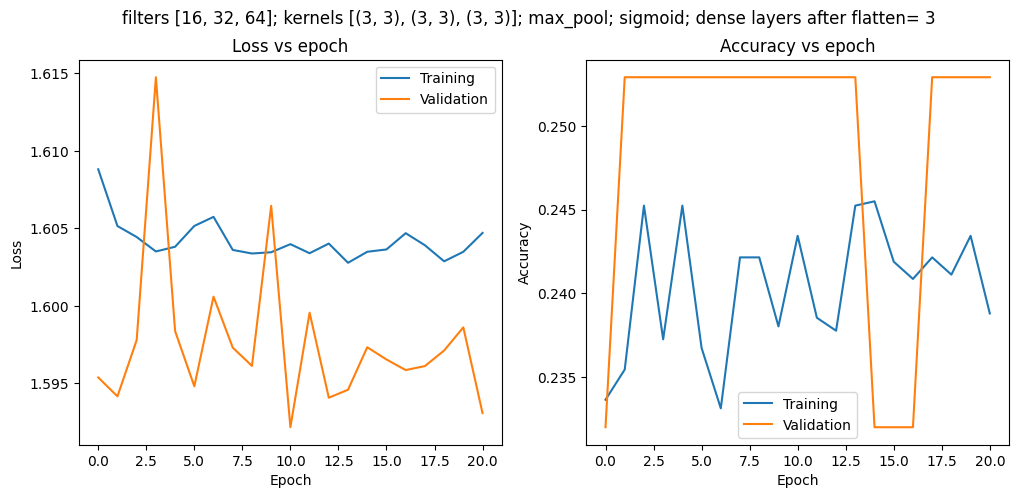

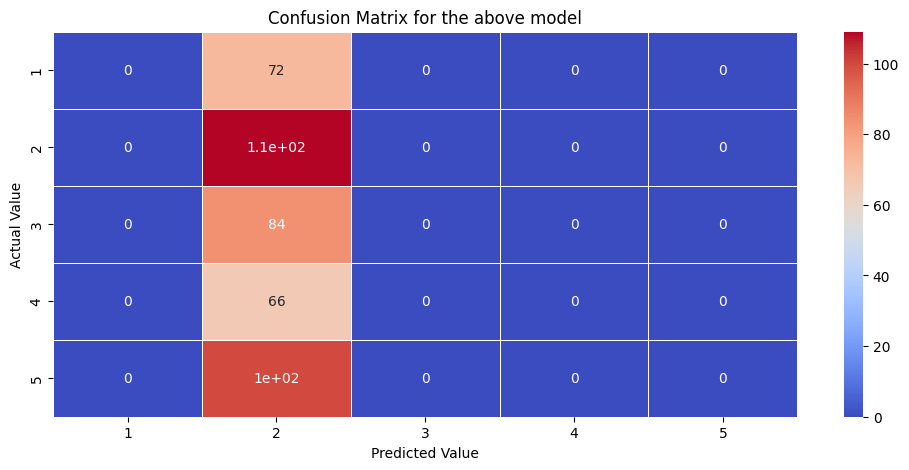

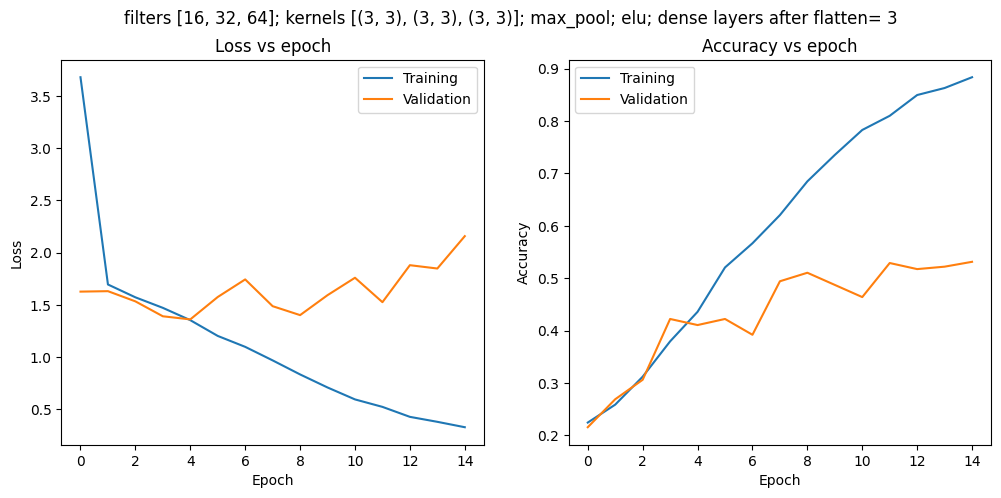

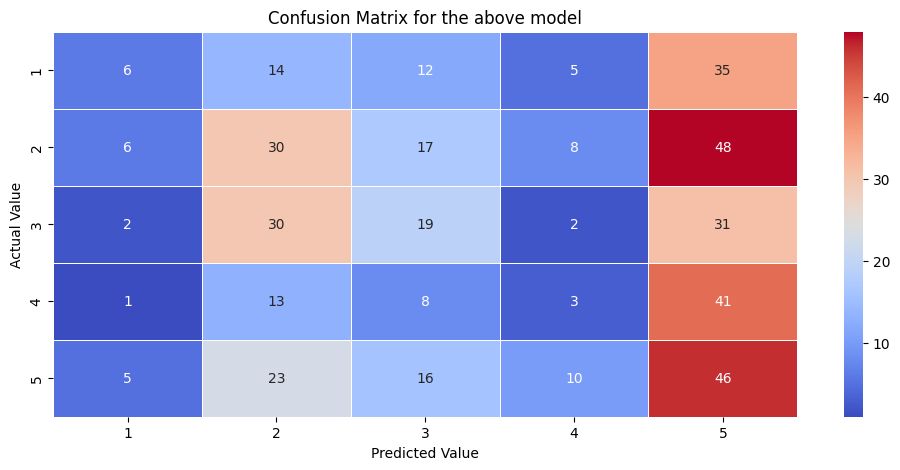

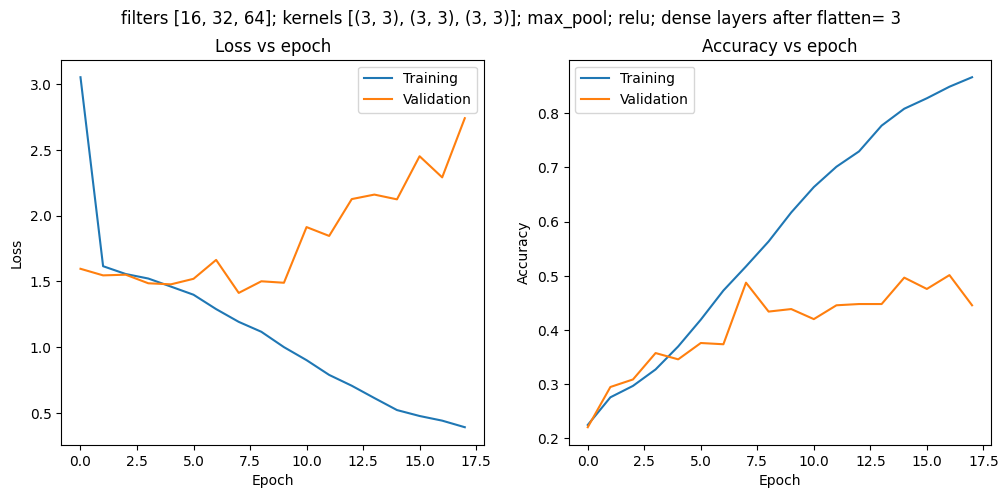

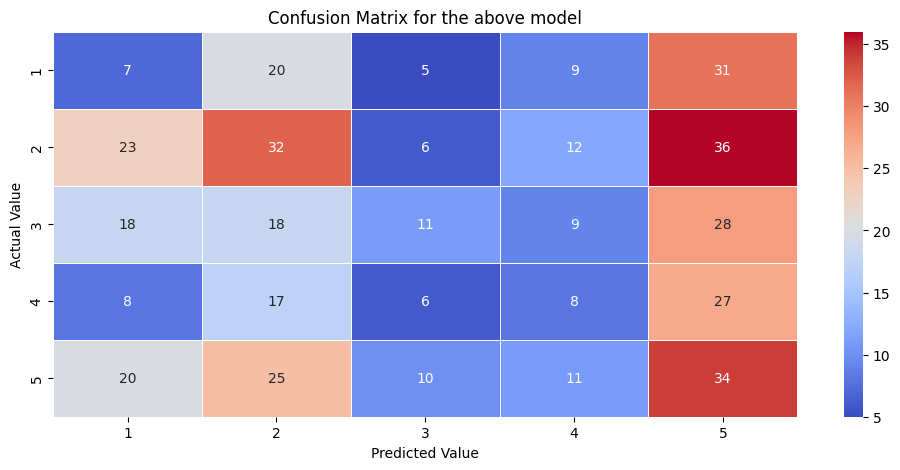

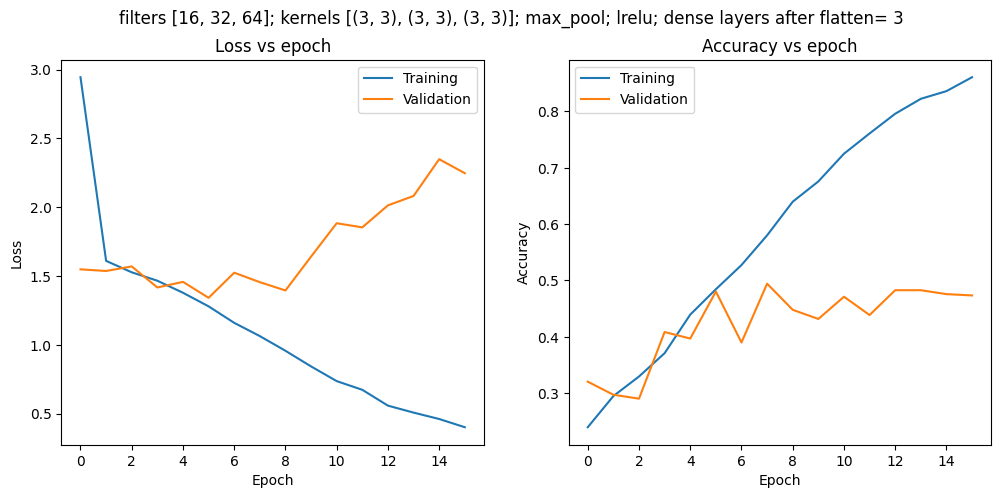

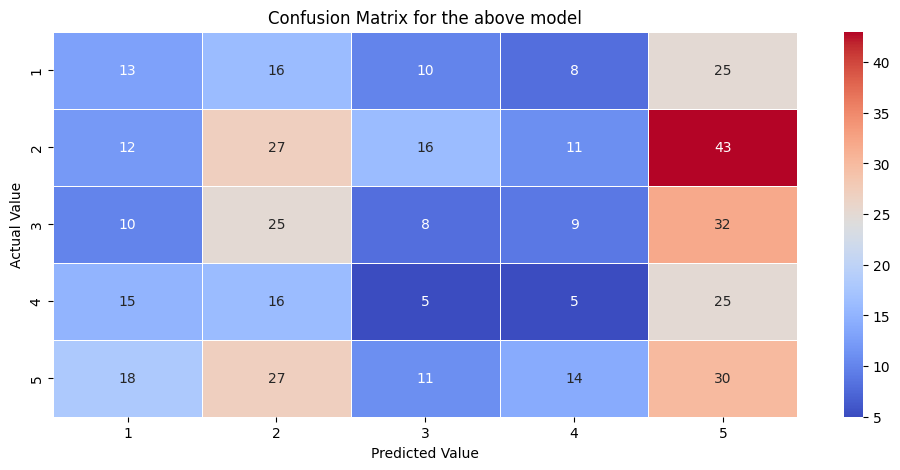

In [21]:
result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall'
])

convolution_filters = [16, 32, 64]
activations = ['sigmoid', 'elu', 'relu', 'lrelu']
dropout_rate = 0.1

for activation in activations:
    val_loss, val_acc, val_precision, val_recall = train_model(
        drop_rate=dropout_rate,
        conv_kernels=best_conv_kernel,
        conv_filters=convolution_filters,
        activation=activation,
        pool=best_pool,
        num_fc_layers=best_num_fc_layers,
        train_dataset=train_dataset,
        val_dataset=val_dataset
    )

    result.loc[len(result.index)] = [
        best_conv_kernel,
        convolution_filters,
        best_pool,
        activation,
        best_num_fc_layers,
        dropout_rate,
        val_loss,
        val_acc,
        val_precision,
        val_recall
    ]


In [22]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation f1
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,sigmoid,3,0.1,1.592165,0.252900,0.000000,0.000000,NaN
1,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,elu,3,0.1,1.359851,0.410673,0.572650,0.155452,0.244526
2,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.1,1.412382,0.487239,0.591743,0.299304,0.397535
3,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,lrelu,3,0.1,1.341453,0.480278,0.650538,0.280742,0.392220


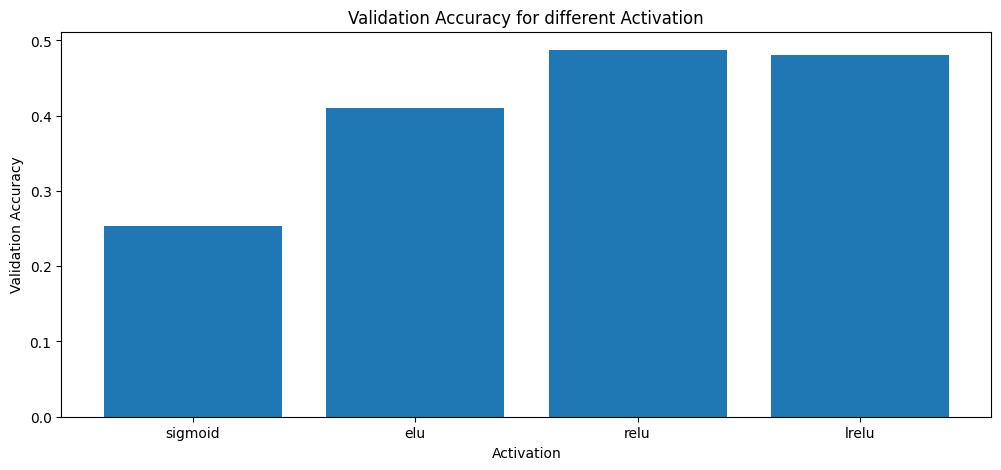

In [23]:
plt.figure(figsize=(12, 5))
plt.bar(
    result['Activation'],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Activation')
plt.title("Validation Accuracy for different Activation")
plt.show()

In [24]:
best_activation = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['Activation'].iloc[0]

best_activation

'relu'

### Task 4.5

For the best set of parameters fromtheaboverunsvarythe regularization parameter:

| Regularization                                                                                     |
|----------------------------------------------------------------------------------------------------|
| Dropout of 0.1 after each layer                                                                    |
| Dropout of 0.25 after each layer                                                                   |
| Batch Normalization after each layer (except the first)                                            |
| Dropout of 0.1 after each layer along with Batch Normalization after each layer (except the first) |

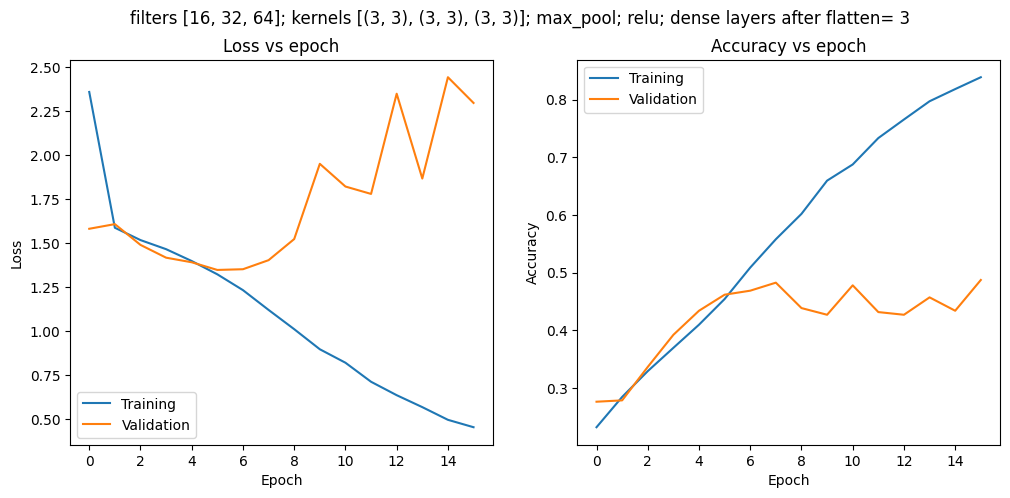

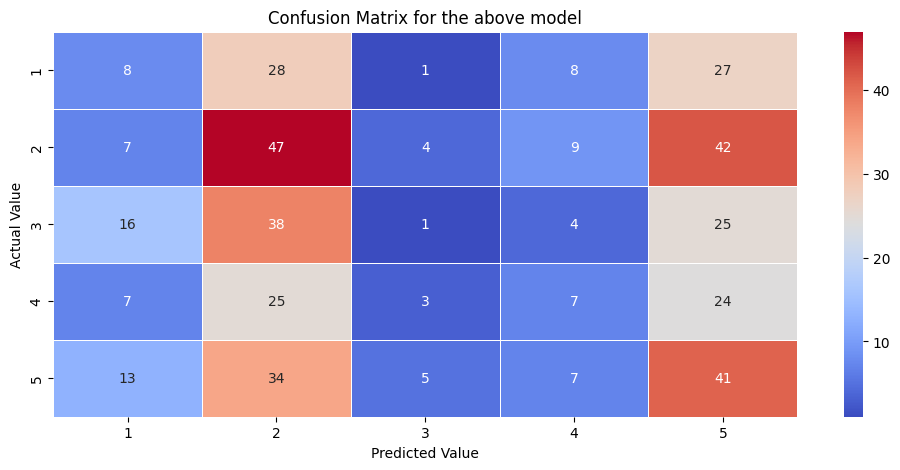

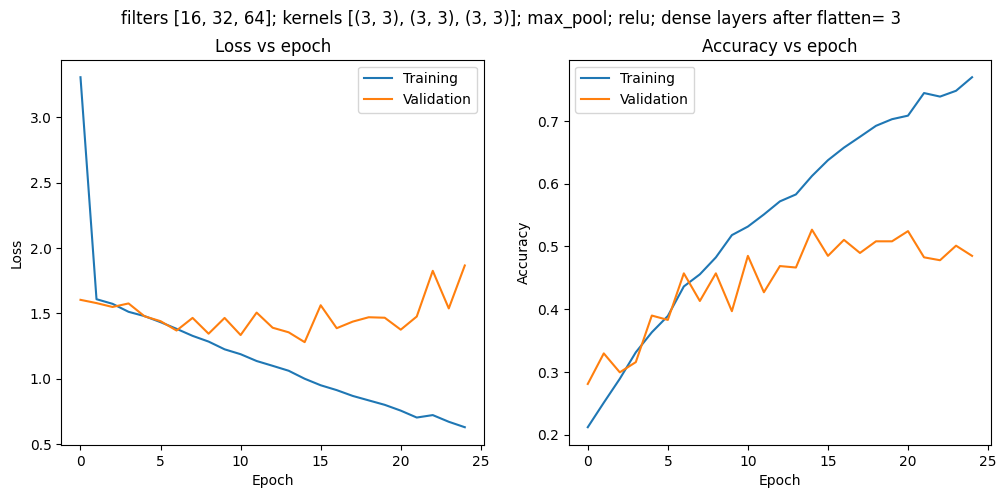

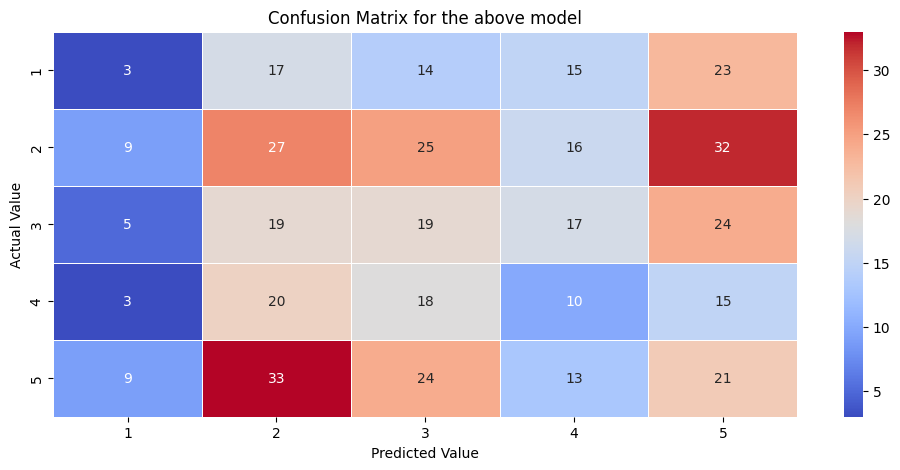

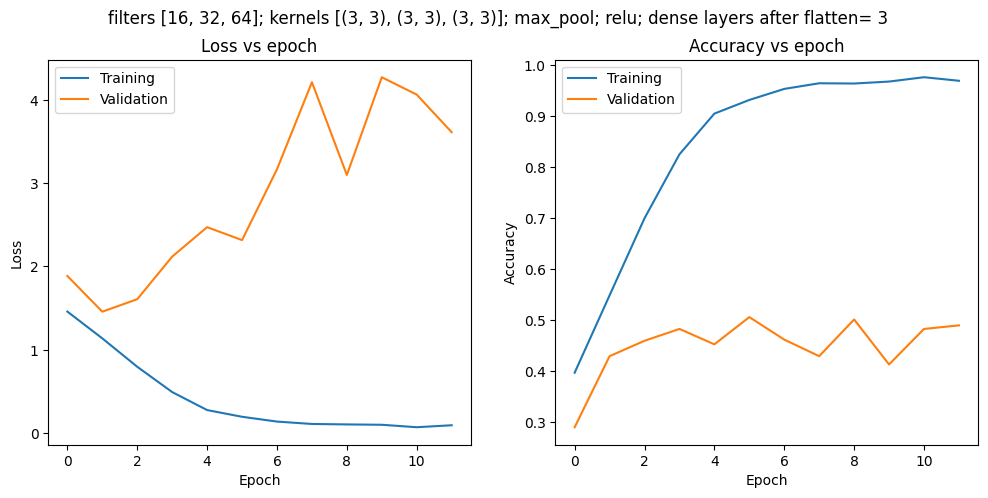

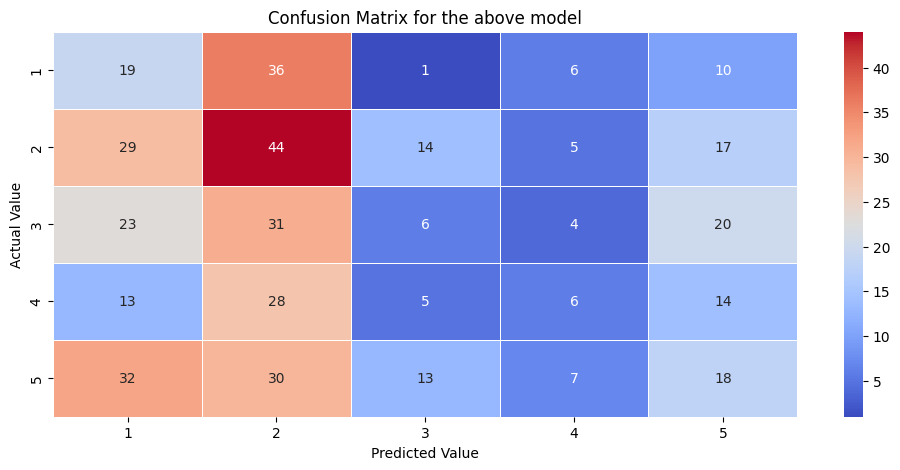

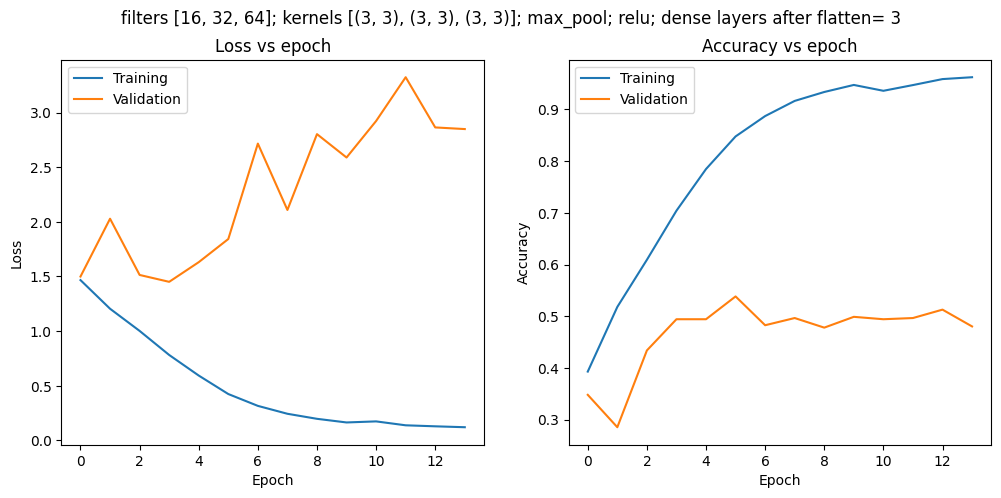

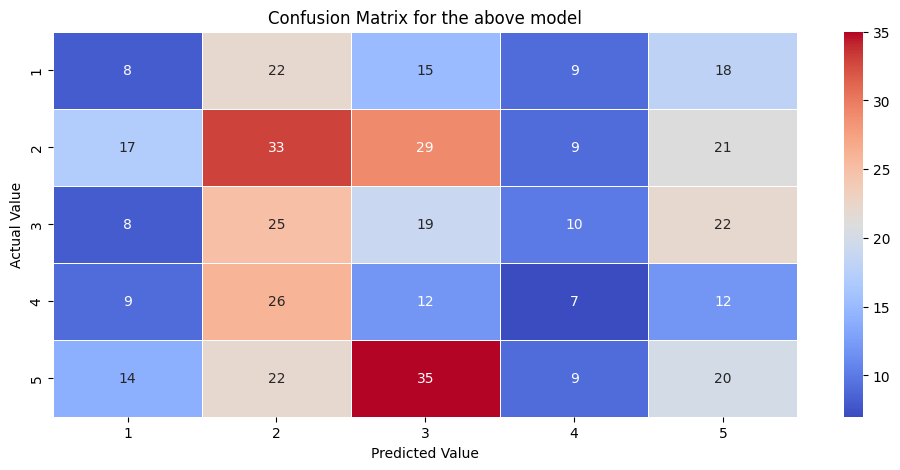

In [25]:
result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Batch Normalization Present',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall'
])

convolution_filters = [16, 32, 64]
dropout_rates = [0.1, 0.25, 0, 0.1]
batch_norm_cases = [False, False, True, True]

for dropout_rate, do_batch in zip(dropout_rates, batch_norm_cases):
    val_loss, val_acc, val_precision, val_recall = train_model(
        drop_rate=dropout_rate,
        conv_kernels=best_conv_kernel,
        conv_filters=convolution_filters,
        activation=best_activation,
        pool=best_pool,
        add_batch_norm=do_batch,
        num_fc_layers=best_num_fc_layers,
        train_dataset=train_dataset,
        val_dataset=val_dataset
    )

    result.loc[len(result.index)] = [
        best_conv_kernel,
        convolution_filters,
        best_pool,
        best_activation,
        best_num_fc_layers,
        dropout_rate,
        do_batch,
        val_loss,
        val_acc,
        val_precision,
        val_recall
    ]


In [26]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Batch Normalization Present,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation f1
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.10,False,1.347827,0.461717,0.685315,0.227378,0.341463
1,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.25,False,1.278649,0.526682,0.679612,0.324826,0.439560
2,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.00,True,1.457688,0.429234,0.549784,0.294664,0.383686
3,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.10,True,1.451055,0.494200,0.547550,0.440835,0.488432


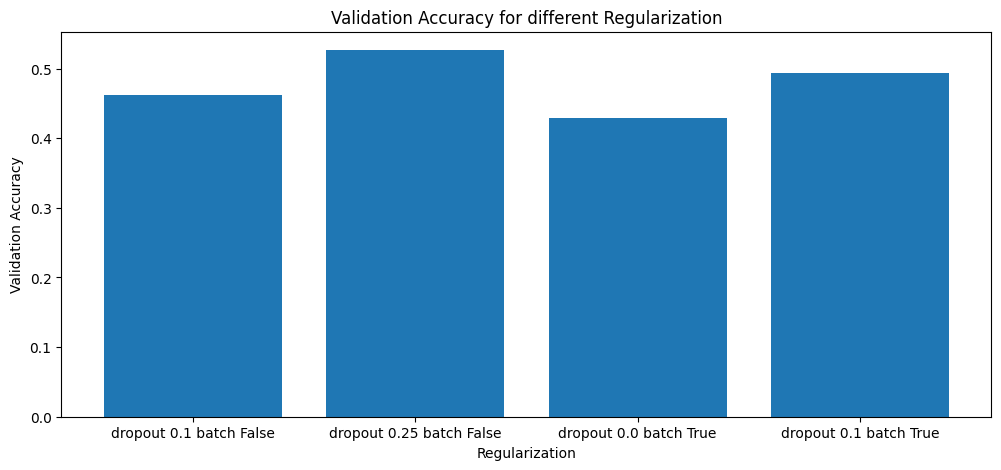

In [27]:
plt.figure(figsize=(12, 5))
plt.bar(
    [f'dropout {drop} batch {batch}' for drop,batch in zip(result['Dropout Rate'], result['Batch Normalization Present'])],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Regularization')
plt.title("Validation Accuracy for different Regularization")
plt.show()

In [28]:
best_dropout = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['Dropout Rate'].iloc[0]

print(f"best dropout rate: {best_dropout}")

best_do_batch = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['Batch Normalization Present'].iloc[0]

print(f"Batch Normalization present for best case: {best_do_batch}")

best dropout rate: 0.25
Batch Normalization present for best case: False


### Task 4.6

For the best set of parameters from the above runs, add \[1,2,3\] more convolution layers, and compare the size of trainable parameters and also compare the time required to train each model for 10 epoch.

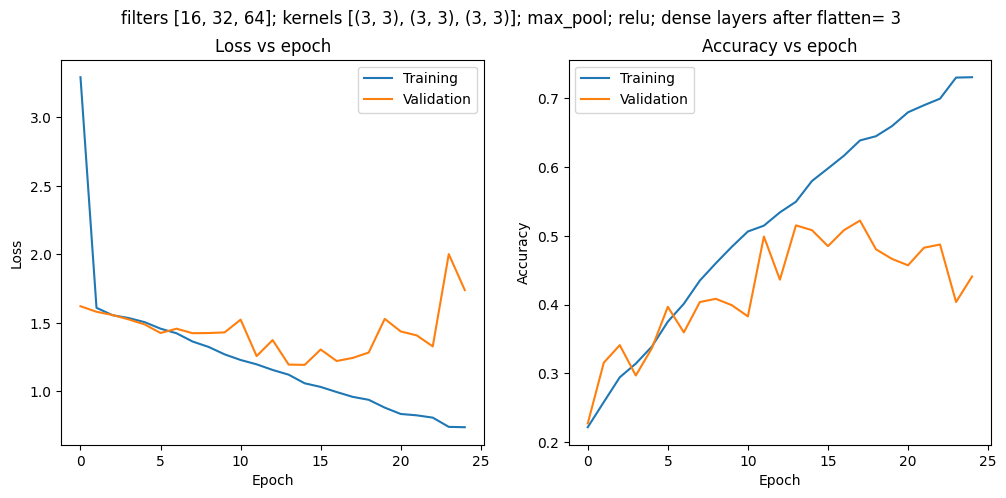

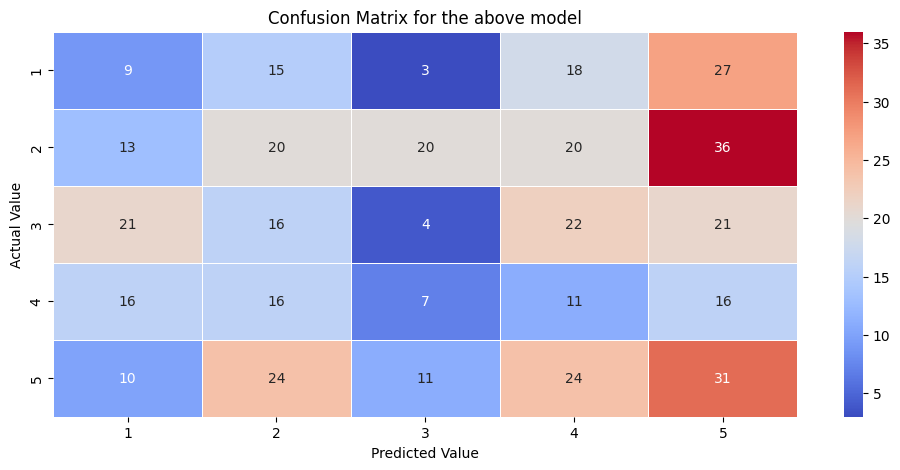

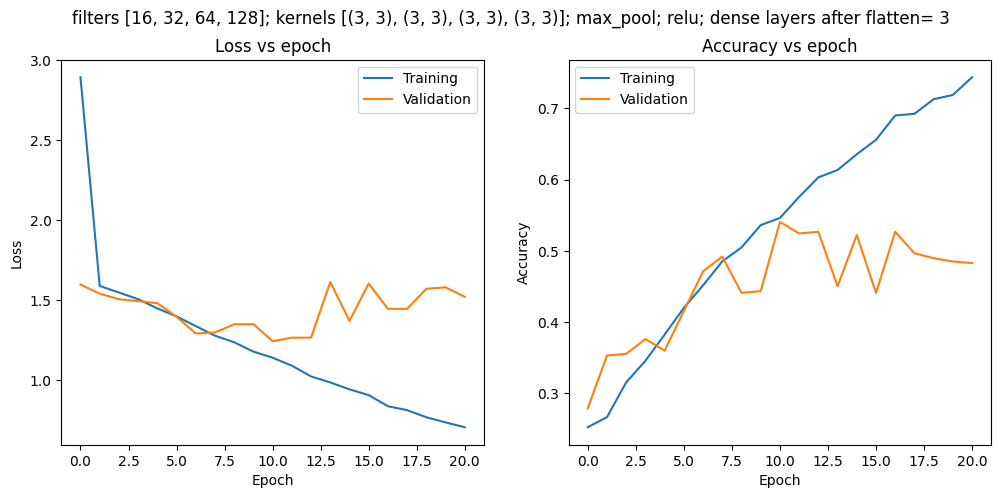

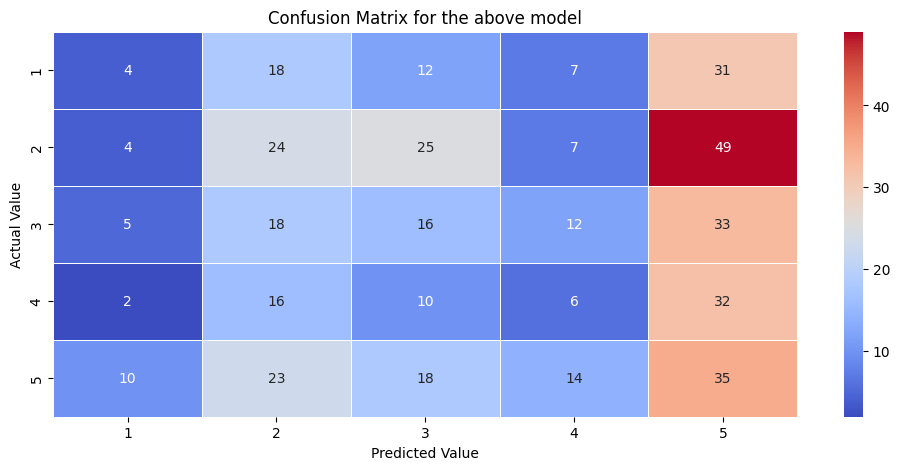

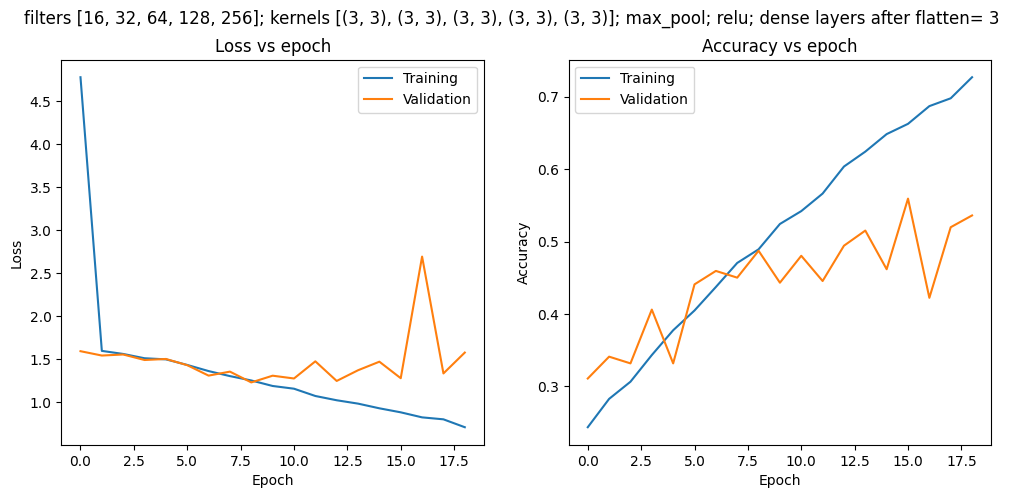

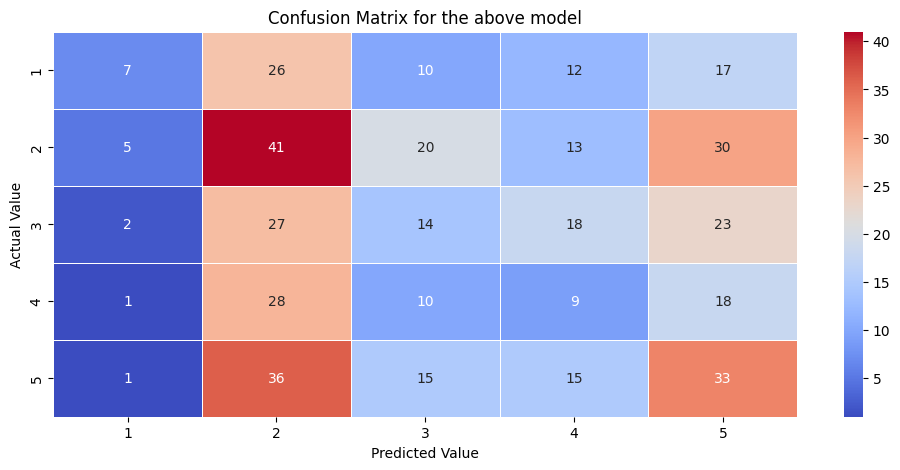

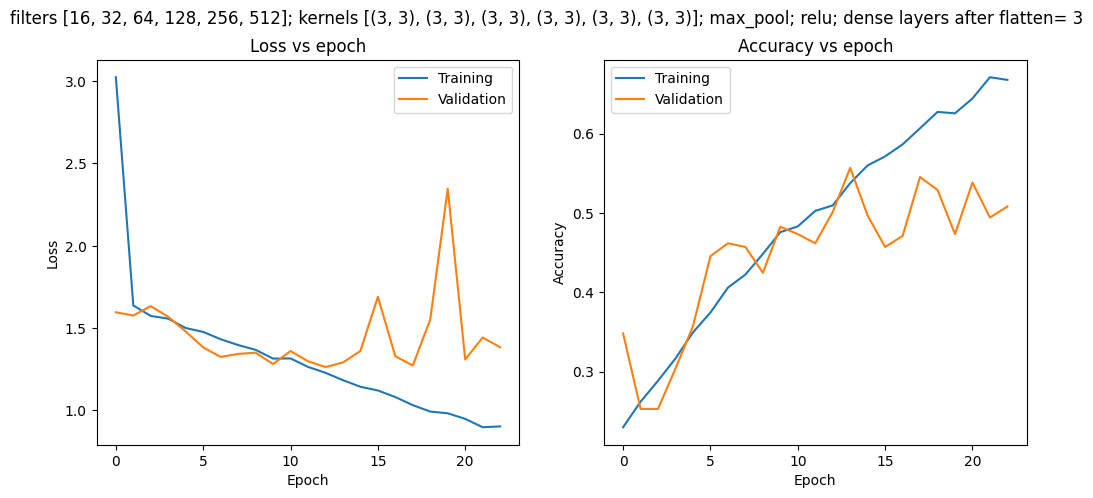

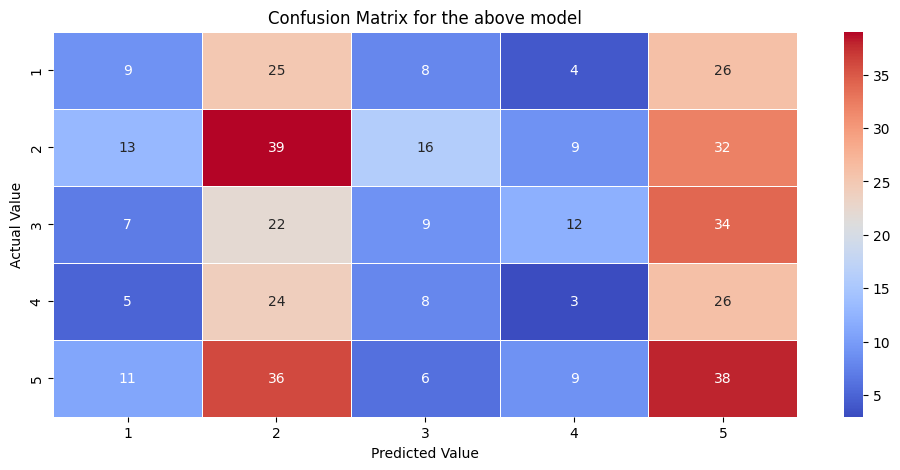

In [31]:
import time

result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Batch Normalization Present',
    'Extra Conv Layers',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall',
    'Time Taken'
])

convolution_filters = [16, 32, 64]
extra_conv_layers = [0, 1, 2, 3]

for extra_conv_layer in extra_conv_layers:
    # making a deep copy to avoid editing of original element
    convolution_filters_copy = []
    best_conv_kernel_copy = []

    for filtr, kernel in zip(convolution_filters, best_conv_kernel):
        convolution_filters_copy.append(filtr)
        best_conv_kernel_copy.append(kernel)

    start_time = time.time()

    val_loss, val_acc, val_precision, val_recall = train_model(
        drop_rate=best_dropout,
        conv_kernels=best_conv_kernel_copy,
        conv_filters=convolution_filters_copy,
        activation=best_activation,
        pool=best_pool,
        add_batch_norm=best_do_batch,
        num_fc_layers=best_num_fc_layers,
        extra_conv_layers=extra_conv_layer,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
    )
    end_time = time.time()

    time_taken = end_time - start_time

    result.loc[len(result.index)] = [
        best_conv_kernel_copy,
        convolution_filters_copy,
        best_pool,
        best_activation,
        best_num_fc_layers,
        best_dropout,
        best_do_batch,
        extra_conv_layer,
        val_loss,
        val_acc,
        val_precision,
        val_recall,
        time_taken
    ]


In [32]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Batch Normalization Present,Extra Conv Layers,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Time Taken,Validation f1
0,"[(3, 3), (3, 3), (3, 3)]","[16, 32, 64]",max,relu,3,0.25,False,0,1.192811,0.508121,0.685990,0.329466,117.652208,0.445141
1,"[(3, 3), (3, 3), (3, 3), (3, 3)]","[16, 32, 64, 128]",max,relu,3,0.25,False,1,1.241910,0.540603,0.693396,0.341067,101.209661,0.457232
2,"[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]","[16, 32, 64, 128, 256]",max,relu,3,0.25,False,2,1.229337,0.487239,0.757576,0.232019,98.763388,0.355240
3,"[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]","[16, 32, 64, 128, 256, 512]",max,relu,3,0.25,False,3,1.263701,0.501160,0.726776,0.308585,118.174041,0.433225


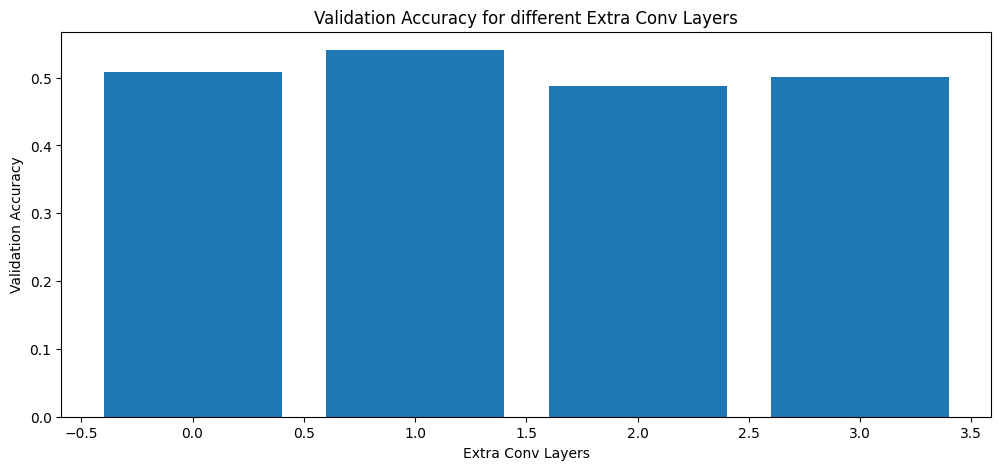

In [33]:
plt.figure(figsize=(12, 5))
plt.bar(
    result['Extra Conv Layers'],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Extra Conv Layers')
plt.title("Validation Accuracy for different Extra Conv Layers")
plt.show()

In [34]:
best_extra_conv_layer = result.sort_values(
    by=['Validation Accuracy', 'Validation Loss'],
    ascending=[False, True]
    )['Extra Conv Layers'].iloc[0]

best_extra_conv_layer

1

### Task 4.7

For the best set of parameters obtained here repeat the experimentation for color images. And visualize the test result.

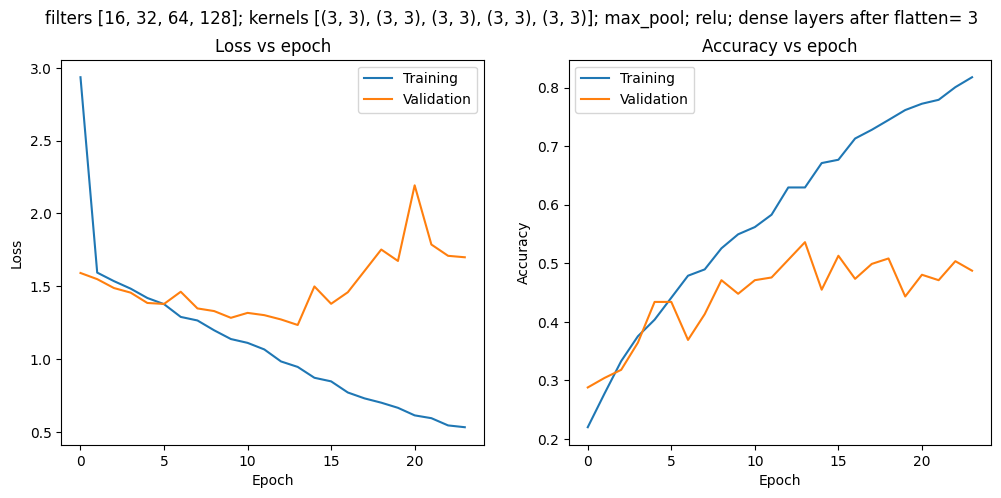

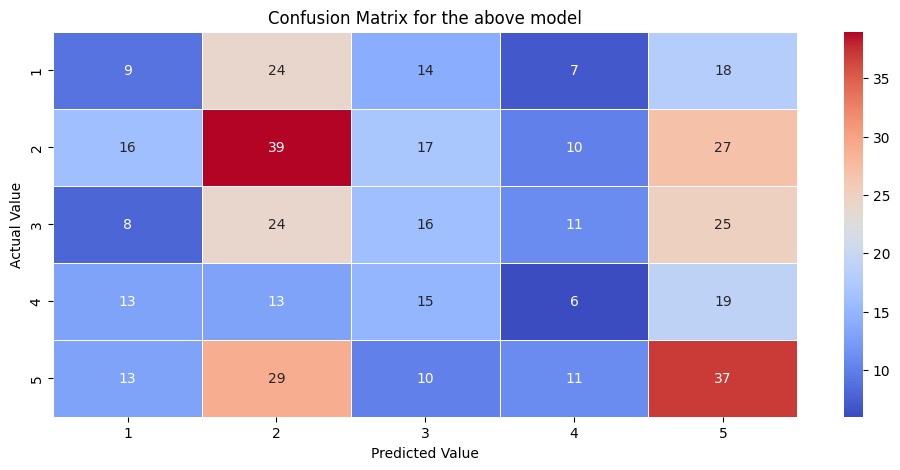

Found 4317 files belonging to 5 classes.
Using 3886 files for training.
Found 4317 files belonging to 5 classes.
Using 431 files for validation.


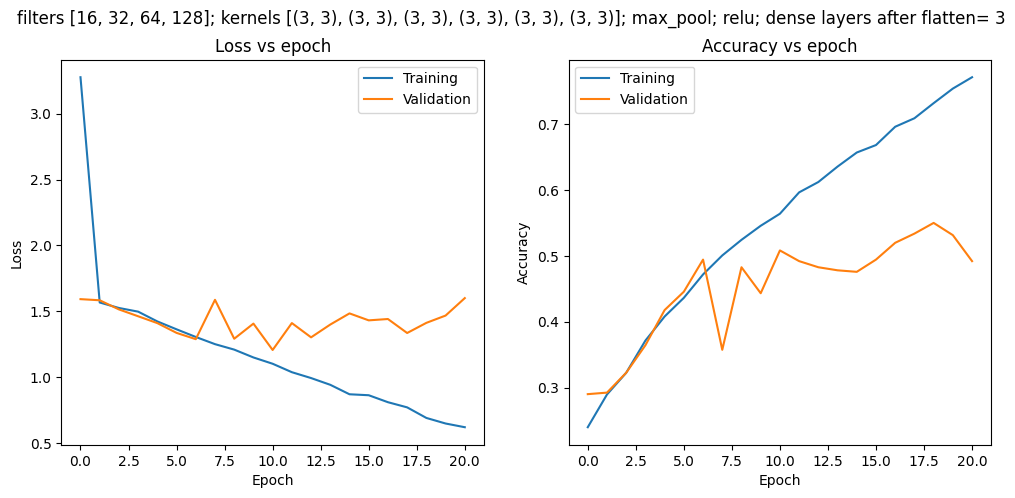

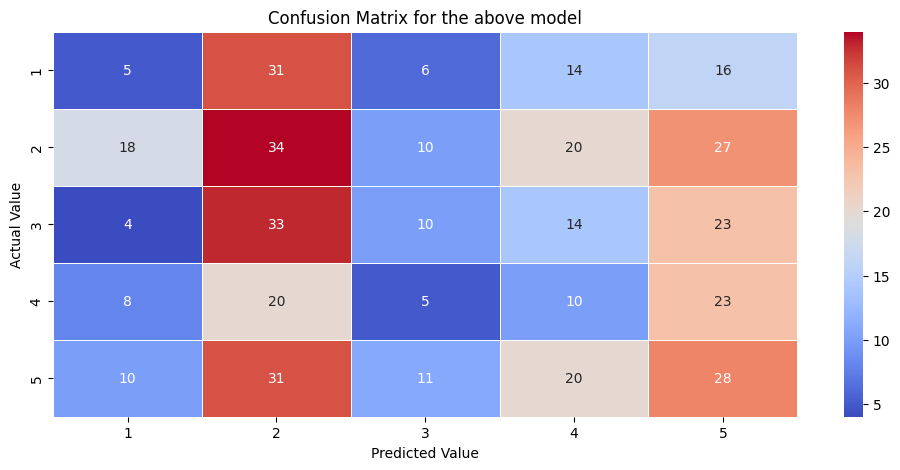

In [36]:
result = pd.DataFrame(columns=[
    'Convolution kernel_size',
    'Convolution filters size',
    'Pooling Layers',
    'Activation',
    'FC layer (after Flatten)',
    'Dropout Rate',
    'Batch Normalization Present',
    'Extra Conv Layers',
    'Color Mode',
    'Validation Loss',
    'Validation Accuracy',
    'Validation Precision',
    'Validation Recall',
])

convolution_filters = [16, 32, 64]

val_loss, val_acc, val_precision, val_recall = train_model(
    drop_rate=best_dropout,
    conv_kernels=best_conv_kernel,
    conv_filters=convolution_filters,
    activation=best_activation,
    pool=best_pool,
    add_batch_norm=best_do_batch,
    num_fc_layers=best_num_fc_layers,
    extra_conv_layers=best_extra_conv_layer,
    train_dataset=train_dataset,
    val_dataset=val_dataset
)

result.loc[len(result.index)] = [
    best_conv_kernel,
    convolution_filters,
    best_pool,
    best_activation,
    best_num_fc_layers,
    best_dropout,
    best_do_batch,
    best_extra_conv_layer,
    'grayscale',
    val_loss,
    val_acc,
    val_precision,
    val_recall

]

convolution_filters = [16, 32, 64]

color_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIRECTORY_PATH,
    labels="inferred",
    label_mode="categorical",  # output of model will be softmax categorical
    color_mode="rgb",
    batch_size=32,
    image_size=(80, 80),
    shuffle=True,
    seed=seed,  # same seed for both dataset so that no overlap happens
    validation_split=0.1,  # 90:10 split
    subset='training',
    crop_to_aspect_ratio=False,
)

color_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIRECTORY_PATH,
    labels="inferred",
    label_mode="categorical",  # output of model will be softmax categorical
    color_mode="rgb",
    batch_size=32,
    image_size=(80, 80),
    shuffle=True,
    seed=seed,
    validation_split=0.1,  # 90:10 split
    subset='validation',
    crop_to_aspect_ratio=False,
)

val_loss, val_acc, val_precision, val_recall = train_model(
    drop_rate=best_dropout,
    conv_kernels=best_conv_kernel,
    conv_filters=convolution_filters,
    activation=best_activation,
    pool=best_pool,
    add_batch_norm=best_do_batch,
    num_fc_layers=best_num_fc_layers,
    extra_conv_layers=best_extra_conv_layer,
    train_dataset=train_dataset,
    val_dataset=val_dataset
)

result.loc[len(result.index)] = [
    best_conv_kernel,
    convolution_filters,
    best_pool,
    best_activation,
    best_num_fc_layers,
    best_dropout,
    best_do_batch,
    best_extra_conv_layer,
    'rgb',
    val_loss,
    val_acc,
    val_precision,
    val_recall
]


In [37]:
result['Validation f1'] = \
    2*result['Validation Precision']*result['Validation Recall']/(result['Validation Precision'] + result['Validation Recall'])
result

,Convolution kernel_size,Convolution filters size,Pooling Layers,Activation,FC layer (after Flatten),Dropout Rate,Batch Normalization Present,Extra Conv Layers,Color Mode,Validation Loss,Validation Accuracy,Validation Precision,Validation Recall,Validation f1
0,"[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]","[16, 32, 64, 128]",max,relu,3,0.25,False,1,grayscale,1.234612,0.535963,0.665217,0.354988,0.462935
1,"[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]","[16, 32, 64, 128]",max,relu,3,0.25,False,1,rgb,1.205759,0.508121,0.714286,0.371230,0.488550


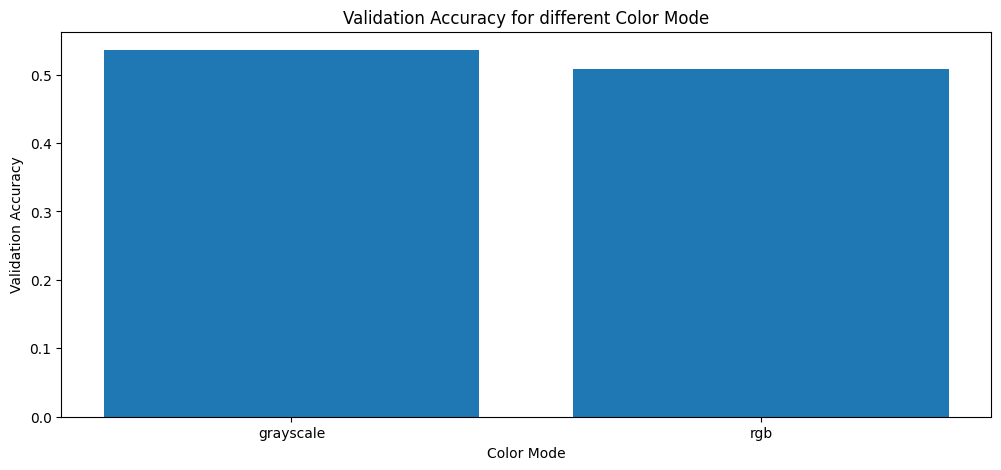

In [38]:
plt.figure(figsize=(12, 5))
plt.bar(
    result['Color Mode'],
    result['Validation Accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Color Mode')
plt.title("Validation Accuracy for different Color Mode")
plt.show()

## Task 5

Plot the graph for the loss vs epoch and accuracy(train, test set) vs epoch for all the above cases. Also, plot the accuracy for all experimentation in a bar graph along with the confusion matrix and F1 score

## Task 6

